## Import necessary libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

## Load the dataset

In [9]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(df.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

## Clean and preprocess data

In [ ]:
replace_cols = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in replace_cols:
    df[col] = df[col].replace({'No phone service': 'No', 'No internet service': 'No'})
# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')


# Step 4: Tenure interval creation
def group_tenure(tenure):
    if tenure <= 6:
        return '0-6 Month'
    elif tenure <= 12:
        return '6-12 Month'
    elif tenure <= 24:
        return '12-24 Month'
    elif tenure <= 36:
        return '24-36 Month'
    elif tenure <= 48:
        return '36-48 Month'
    elif tenure <= 62:
        return '48-62 Month'
    else:
        return '> 62 Month'

df['tenure_interval'] = df['tenure'].apply(group_tenure)
df.drop(columns=['tenure'], inplace=True)

# Convert target column
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# One-hot encode categorical features
df = pd.get_dummies(df, drop_first=True)


## Train-test split

In [23]:
X = df.drop(columns=['Churn'])
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Train logistic regression model

In [26]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

##  Predict and evaluate

In [30]:
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred_class = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_class)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred_class))

Accuracy: 0.8014218009478673

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.93      0.87      1484
           1       0.75      0.50      0.60       626

    accuracy                           0.80      2110
   macro avg       0.78      0.71      0.73      2110
weighted avg       0.80      0.80      0.79      2110



## Confusion Matrix

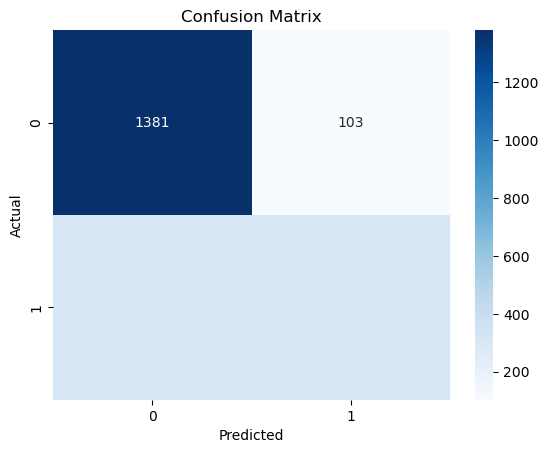

In [33]:
cm = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## SHAP Explanation

In [36]:
explainer = shap.Explainer(model, X_train, feature_names=X.columns)
shap_values = explainer(X_test[:100])


## Summary plot

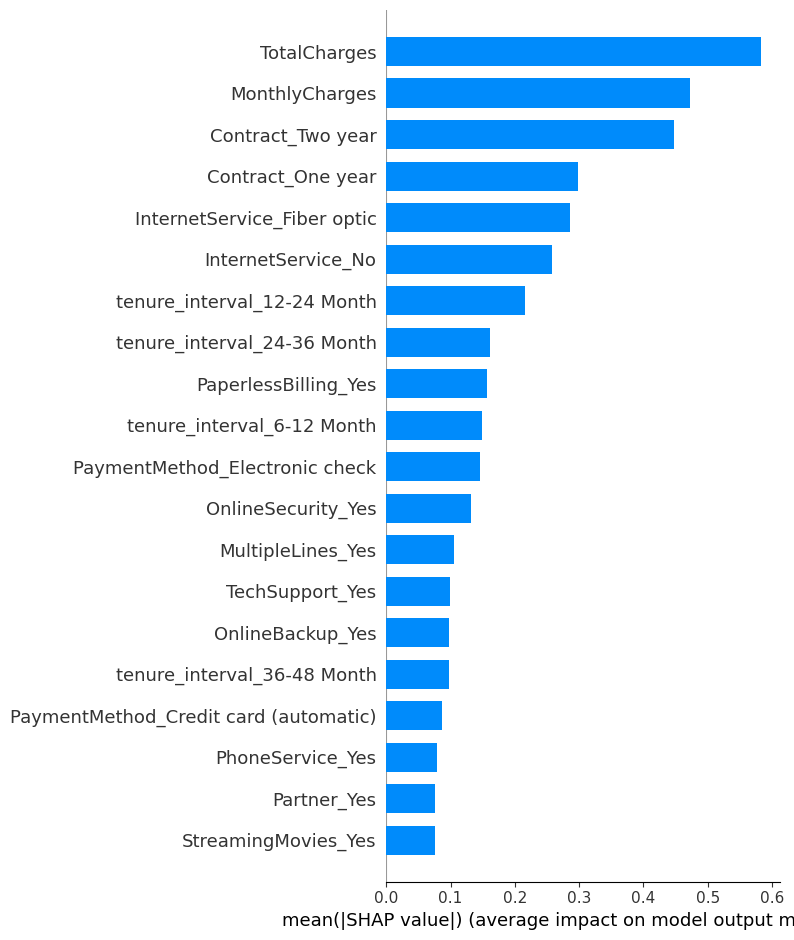

In [39]:
shap.summary_plot(shap_values, X_test[:100], plot_type="bar")